# Import libraries needed


In [5]:
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from elasticsearch import Elasticsearch
import spacy
import os
from datetime import datetime
from dateutil import parser
import re
from elasticsearch.helpers import bulk

# Define Elasticsearch and index mapping


In [6]:
es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200, 'scheme': 'http'}],basic_auth=('osama', 'osama123'))

In [7]:
index_mapping = {
    'mappings': {
        'properties': {
            "title": {
                "type": "text",
                "analyzer": "title_analyzer",
                "search_analyzer": "standard"
            },
            'content': {
                'type': 'text',
                'analyzer': 'content_analyzer'
            },
            "authors": {
                "type": "nested",
                "properties": {
                    "first_name": {
                        "type": "text"
                    },
                    "last_name": {
                        "type": "text"
                    }
                }
            },
            "date": {
                "type": "date"
            },
            "geopoint": {
                "type": "geo_point"
            },
            "temporal_expressions": {
                "type": "nested",
                "properties": {
                    "temporal": {"type": "text"},
                }
            },
            "georeferences": {
                "type": "nested",
                "properties": {
                    "reference": {
                        "type": "text",
                        "fields": {
                            "keyword": {
                                "type": "keyword"
                            }
                        }
                    }
                },
            },
        },
    },
    "settings": {
        "analysis": {
            "filter": {
                "length_3_to_10_char": {"type": "length", "min": 3},
            },
            "analyzer": {
                "title_analyzer": {
                    "type": "custom",
                    "tokenizer": "autocomplete_tokenizer",
                    "filter": [
                        "lowercase"
                    ]
                },
                "content_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "char_filter": [
                        "html_strip"
                    ],
                    "filter": [
                        "lowercase",
                        "stop",
                        "length_3_to_10_char",
                        "porter_stem"
                    ]
                }
            },
            "tokenizer": {
                "autocomplete_tokenizer": {
                    "type": "edge_ngram",
                    "min_gram": 3, 
                    "max_gram": 10,
                    "token_chars": [
                        "letter",
                        "digit"
                    ]
                }
            }
        }
    }
}

index_name = "reuter_index"
es.indices.create(index=index_name, body=index_mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'reuter_index'})

In [8]:
# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Data Extracting for all fields

- Use the `extract date` function to extract dates from data and make sure it is applicable with Elasticsearch.


In [24]:
def extract_date(reuters_tag):
    """
    Parameters:
    - reuters_tag: A BeautifulSoup Tag object representing a 'reuters' element with the date information.

    Return:
    - A formatted date string in Elasticsearch-friendly format if the 'date' tag is present; otherwise, returns None.
    """
    date_tag = reuters_tag.find('date')
    
    if date_tag:
        date_text = date_tag.get_text()
        parsed_date = parser.parse(date_text)
        elasticsearch_date = parsed_date.isoformat()

        return elasticsearch_date

    return None

- Use `extract_first_last_names` function to split the author name into the first and last names from the `author tag` in the data.

- Use `extract_author` function to extract the author's name from the data.


In [25]:
def extract_first_last_names(author_tag):
    # Extract author information from the given tag
    author_info = author_tag.get_text() if author_tag else None
    
    # Check if author_info is not None before proceeding
    if author_info:
        # Define a case-insensitive regular expression pattern to extract the full author's name
        pattern = re.compile(r'by (.*?),', re.IGNORECASE)

        # Use the regular expression to find the match
        match = re.search(pattern, author_info)

        # Extract the full author's name
        full_name = match.group(1) if match else None

        # Split the full name into first and last names
        if full_name:
            names = full_name.split()
            first_name = names[0] if names else None
            last_name = names[-1] if len(names) > 1 else None
            return first_name, last_name
    return None, None

def extract_authors(reuters_tag):
    author_tag = reuters_tag.find('author')
    return extract_first_last_names(author_tag)

- Use `extract_article_title` function to extract the article's title from the data `title` tag.


In [26]:
def extract_article_title(reuters_tag):
    title_tag = reuters_tag.find('title')
    return title_tag.get_text() if title_tag else None

- Use `clean_text` function to remove unnecessary spaces and some special characters, like `\n`.

- Use `extract_content` function to extract the content of news content from the data `text` tag.


In [27]:
def clean_text(raw_text):
    # Remove control characters and extra spaces
    cleaned_text = re.sub(r'[\x00-\x1F\x7F-\x9F]+', ' ', raw_text)

    # Remove leading and trailing whitespaces
    cleaned_text = cleaned_text.strip()

    return cleaned_text

def extract_content(reuters_tag):
    text_tag = reuters_tag.find('text')
    raw_content = text_tag.get_text() if text_tag else None

    # Use clean_text function to clean the extracted content
    cleaned_content = clean_text(raw_content) if raw_content else None

    return cleaned_content

- Use `extract_georeferences` to extract places and then send result of this function to `extract_geopoints` to get the location of place using

- `geocode` method from `geopy` library to get latitude and longitude of this place.


In [28]:
def extract_georeferences(reuters_tag):
    places_tag = reuters_tag.find('places')
    return [place.get_text() for place in places_tag.find_all('d')] if places_tag else None

- Use `extract_temporal_expressions` to extract temporal expressions from the content of news using `spacy` library.
- Analysis the text, the ent read text and get entites of text and return text.lebl == 'DATE' to return temporal expressions.


In [29]:
def extract_temporal_expressions(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == 'DATE']

- Use `extract_geopoints` to convert place name to coordinates by get the location of place using `geocode` method from `geopy` library
- to return latitude and longitude of this place.


In [30]:
def extract_geopoints(georeferences):
    geolocator = Nominatim(user_agent="geo_app")
    geopoints = []
    
    for place_name in georeferences:
        location = geolocator.geocode(place_name)
        if location:
            geopoints.append({'latitude': location.latitude, 'longitude': location.longitude})
    return geopoints

# Data indexing

- Excluding documents that do not contain a `title` or `content`


In [31]:
def generate_documents(reuters_tags):
    for reuters_tag in reuters_tags:
        date = extract_date(reuters_tag)
        first_name, last_name = extract_authors(reuters_tag)
        title = extract_article_title(reuters_tag)
        file_content = extract_content(reuters_tag)
        georeferences = extract_georeferences(reuters_tag)
        temporal_expressions = extract_temporal_expressions(file_content)

        if not file_content or not title:
            continue
        
        if georeferences:
            geopoints = extract_geopoints(georeferences)
        else:
            geopoints = None

        document = {
            '_op_type': 'index',
            '_index': 'reuter_index',
            '_source': {
                'title': title,
                'content': file_content,
                'date': date,
                'authors': [{'first_name': first_name, 'last_name': last_name}],
                'geopoint': [{'lat': point['latitude'], 'lon': point['longitude']} for point in geopoints] if geopoints else [],
                'temporal_expressions': [{'temporal': expression} for expression in temporal_expressions],
                'georeferences': [{'reference': reference} for reference in georeferences] if georeferences else []
            }
        }
        
        yield document

def bulk_index_documents(reuters_tags):
    try:
        success, failed = bulk(es, generate_documents(reuters_tags))
        print(f"Successfully indexed {success} documents.")
        if failed:
            print(f"Failed to index {len(failed)} documents.")
            for item in failed:
                print(f"Error indexing document: {item['index']['error']}")
    except Exception as e:
        print(f"Error during bulk indexing: {e}")

In [ ]:
def read_file_and_bulk_index(folder_path):
    all_reuters_tags = []
    batch_size = 100
    count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".sgm"):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='latin-1') as file:
                    content = file.read()

                soup = BeautifulSoup(content, 'html.parser')
                reuters_tags = soup.find_all('reuters')
                all_reuters_tags.extend(reuters_tags)

                count += len(reuters_tags)

                if count >= batch_size:
                    bulk_index_documents(all_reuters_tags)
                    print(f"Indexed {count} documents.")
                    all_reuters_tags = []
                    count = 0

            except Exception as e:
                print(f"Error reading or indexing file '{file_path}': {e}")

    if all_reuters_tags:
        bulk_index_documents(all_reuters_tags)

data_folder = "./archive"

read_file_and_bulk_index(data_folder)

In [36]:
def relevant_docs(query, temporal_expression, georeference):
    es_query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "multi_match": {
                            "query": query,
                            "fields": ["title^2", "content"]
                        }
                    },
                    {
                        "nested": {
                            "path": "temporal_expressions",
                            "query": {
                                "match": {
                                    "temporal_expressions.temporal": temporal_expression
                                }
                            }
                        }
                    },
                    {
                        "nested": {
                            "path": "georeferences",
                            "query": {
                                "match": {
                                    "georeferences.reference": georeference
                                }
                            }
                        }
                    }
                ]
            }
        },
        "sort": [
            {"date": {"order": "desc"}}  # (recency)
        ]
    }

    # Execute the query
    result = es.search(index='reuter_index', body=es_query)

    # Extract relevant information from the result
    relevant_documents = [
        {
            'title': hit['_source']['title'],
            'date': hit['_source']['date'],
        }
        for hit in result['hits']['hits']
    ]

    return relevant_documents

# Example usage
query = "TALKING"
temporal_expression = "this week"
georeference = "brazil"

results = relevant_docs(query, temporal_expression, georeference)
results

[{'title': 'STOLTENBERG CALLS FOR NEW BRAZIL TALKS WITH BANKS',
  'date': '1987-04-03T08:50:09.710000'},
 {'title': 'ICO QUOTAS BEFORE OCTOBER UNLIKELY - DELEGATES',
  'date': '1987-04-01T11:12:00.710000'},
 {'title': 'ICO COFFEE PRODUCERS TO DISCUSS MARKET SITUATION',
  'date': '1987-04-01T08:28:11.350000'},
 {'title': 'COMMODITY PACTS MORE ORIENTED TOWARDS MARKET',
  'date': '1987-03-31T06:07:48.830000'},
 {'title': 'CANADA BANKS COULD SEE PRESSURE ON BRAZIL LOANS',
  'date': '1987-03-30T18:03:22.770000'},
 {'title': 'MULFORD SEES MORE BANK LOANS TO DEBTORS IN 1987',
  'date': '1987-03-26T09:52:24.180000'},
 {'title': "DAUSTER SAYS NO CHANGE IN BRAZIL'S COFFEE POLICY",
  'date': '1987-03-25T19:04:37.950000'},
 {'title': 'ECONOMIC SPOTLIGHT - BRAZIL DEBT DEADLINES LOOM',
  'date': '1987-03-23T15:39:33.720000'},
 {'title': 'BRAZIL DEBT OFFICIAL OFFERS RESIGNATION',
  'date': '1987-03-23T11:08:37.610000'},
 {'title': 'PREMIER SAYS YUGOSLAVIA WILL PAY ITS DEBTS',
  'date': '1987-03-23T07

In [37]:
# Assuming you have the necessary mappings and index created

def top_georeferences():
    # Your Elasticsearch aggregation query
    es_aggregation = {
        "size": 0,
        "aggs": {
            "top_georeferences": {
                "nested": {
                    "path": "georeferences"
                },
                "aggs": {
                    "top_references": {
                        "terms": {
                            "field": "georeferences.reference.keyword",
                            "size": 10  # Return top-10 mentioned georeferences
                        }
                    }
                }
            }
        }
    }

    # Execute the aggregation query
    result = es.search(index='reuter_index', body={"query": {"match_all": {}}, **es_aggregation})

    # Extract relevant information from the result
    top_georeferences = [
        {
            'Ref': bucket['key'],
            'Freq': bucket['doc_count']
        }
        for bucket in result['aggregations']['top_georeferences']['top_references']['buckets']
    ]

    return top_georeferences

# Example usage
top_georeferences_result = top_georeferences()
top_georeferences_result

[{'Ref': 'usa', 'Freq': 6649},
 {'Ref': 'uk', 'Freq': 891},
 {'Ref': 'canada', 'Freq': 598},
 {'Ref': 'japan', 'Freq': 516},
 {'Ref': 'west-germany', 'Freq': 306},
 {'Ref': 'france', 'Freq': 253},
 {'Ref': 'brazil', 'Freq': 207},
 {'Ref': 'australia', 'Freq': 148},
 {'Ref': 'belgium', 'Freq': 130},
 {'Ref': 'china', 'Freq': 127}]

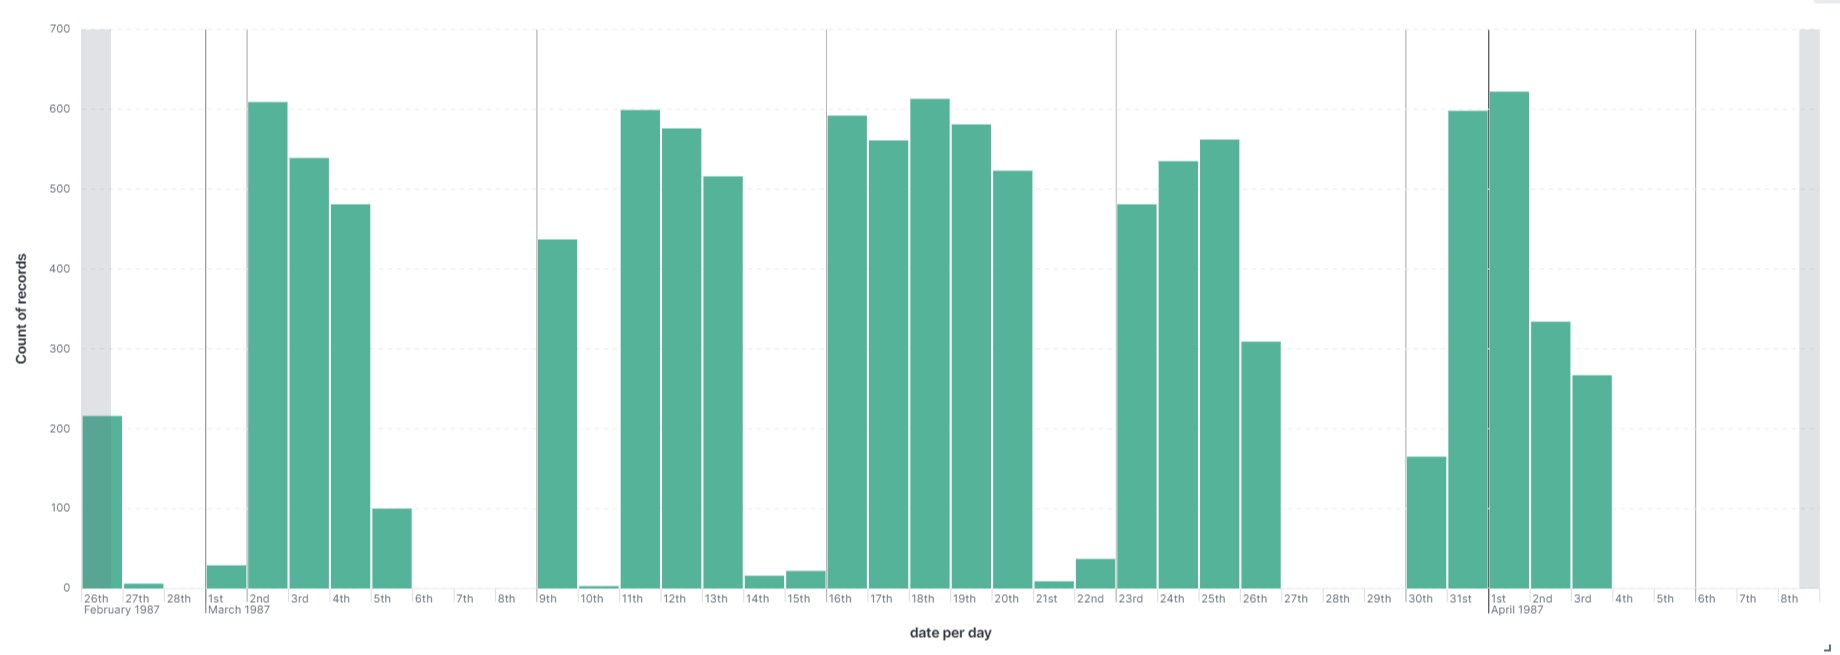

In [39]:
from IPython.display import Image, display

# Specify the path to your image file
image_path = './date per day.png'

# Display the image
display(Image(filename=image_path))